# 시계열 데이터의 Anomaly Detection 방법 비교

- RNN을 이용한 지도학습 방법 - 이진 분류
- Autoencoder 사용 방법 - 재구성 오류 측정
- Variational Autoencoder 사용 방법 - 재구성 오류 측정

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

- 이 연습문제에서는 RNN, 자동 인코더 및 변형 자동 인코더를 사용하여 [ECG5000 데이터 세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지합니다.  이 데이터 세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도가 포함되어 있습니다. 각 예제에 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)로 레이블이 지정된 데이터 세트의 단순화된 버전을 사용할 것입니다. 우리는 비정상적인 리듬을 식별하는 데 관심이 있습니다.   

- "ECG5000"의 원본 데이터세트는 Physionet에서 다운로드한 20시간 길이의 ECG입니다. 이름은 BIDMC 울혈성 심부전 데이터베이스(chfdb)이고 레코드 "chf07"입니다. 

## Load and prepare ECG data

In [9]:
# Dataset Download 
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [10]:
df.iloc[:, -1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [32]:
# labels
labels = df.iloc[:, -1]

# electrocadriogram data의 feature values
data = df.iloc[:, 0:-1]

X_train, X_test, y_train,y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3998, 140), (1000, 140), (3998,), (1000,))

In [33]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

normal, abnormal data 분리

In [36]:
normal_X_train = X_train[y_train]
normal_X_test = X_test[y_test]
normal_y_train = y_train[y_train]
normal_y_test = y_test[y_test]

abnormal_X_train = X_train[~y_train]
abnormal_X_test = X_test[~y_test]
abnormal_y_train = y_train[~y_train]
abnormal_y_test = y_test[~y_test]

print("정상 데이터", normal_X_train.shape, normal_X_test.shape, 
       normal_y_train.shape, normal_y_test.shape)
print("비정상 데이터", abnormal_X_train.shape, abnormal_X_test.shape, 
       abnormal_y_train.shape, abnormal_y_test.shape)

정상 데이터 (2328, 140) (591, 140) (2328,) (591,)
비정상 데이터 (1670, 140) (409, 140) (1670,) (409,)


정상 ECG 시각화

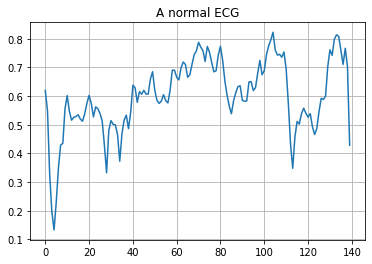

In [37]:
plt.plot(normal_X_train[0])
plt.title("A normal ECG")
plt.grid()
plt.show()

비정상 ECG 시각화

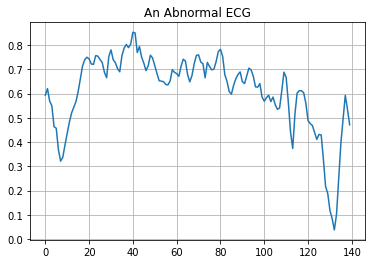

In [38]:
plt.plot(abnormal_X_train[0])
plt.title("An Abnormal ECG")
plt.grid()
plt.show()

### 이상 탐지를 위한 RNN
데이터 세트의 레이블에 액세스할 수 있으므로 이상 감지를 이진 분류 지도 학습 문제로 설정할 수 있습니다. 

In [39]:
X_train_rnn = np.expand_dims(X_train, axis=2)
X_test_rnn = np.expand_dims(X_test, axis=2)
X_train_rnn.shape, X_test_rnn.shape

((3998, 140, 1), (1000, 140, 1))

In [40]:
# RNN 모델 생성
model = tf.keras.Sequential()
model.add(layers.LSTM(100, input_shape=(X_train_rnn.shape[1],X_train_rnn.shape[2])))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam')
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=256)

Epoch 1/20
16/16 [==============================] - 6s 14ms/step - loss: 0.6312
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 0.4077
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 0.2088
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.1482
Epoch 5/20
16/16 [==============================] - 0s 13ms/step - loss: 0.1064
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.1109
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.0994
Epoch 8/20
16/16 [==============================] - 0s 15ms/step - loss: 0.0931
Epoch 9/20
16/16 [==============================] - 0s 14ms/step - loss: 0.0873
Epoch 10/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0832
Epoch 11/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0921
Epoch 12/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0973
Epoch 13/20
16/16 [==================

Text(0.5, 1.0, 'Training Loss')

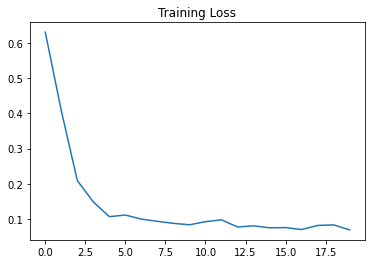

In [42]:
plt.plot(history.history['loss'])
plt.title('Training Loss')

In [43]:
# Test set 정상/비정상 분류
preds = model.predict(X_test_rnn) > 0.5

# metric 계산
accuracy_test_rnn= accuracy_score(preds, y_test)
print('Accuracy = ',accuracy_test_rnn)

precision_test_rnn=precision_score(preds, y_test)
print('Precision = ',precision_test_rnn)

recall_test_rnn=recall_score(preds, y_test)
print('Recall = ',recall_test_rnn)

Accuracy =  0.979
Precision =  0.9746192893401016
Recall =  0.9896907216494846


### 이상 감지를 위한 오토인코더
autoencoder의 목적은 주어진 입력의 재구성 오류를 최소화하는 것입니다. 따라서 우리는 최소한의 오류로 이러한 예를 재구성할 수 있도록 정상 심전도 시퀀스에 대해서만 자동 인코더를 훈련할 것입니다.   
비정상적인 리듬은 정상 시퀀스보다 재구성 오류가 더 높아야 하므로 재구성 오류가 고정 임계값보다 높은 경우의 리듬을 이상으로 분류할 수 있습니다.

In [44]:
class AnomalyDetectorAE(Model):
    def __init__(self):
        super(AnomalyDetectorAE, self).__init__()

        # encoder network
        self.encoder = tf.keras.Sequential([
              Dense(32, activation="relu"),
              Dense(16, activation="relu"),
              Dense(8, activation="relu")])

        # decoder network
        self.decoder = tf.keras.Sequential([
              Dense(16, activation="relu"),
              Dense(32, activation="relu"),
              Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetectorAE()

In [45]:
autoencoder.compile(optimizer='adam', loss='mae')

오토인코더는 정상 ECG만 사용하여 훈련됩니다.

In [46]:
history = autoencoder.fit(normal_X_train, normal_X_train, 
                                      epochs=20, batch_size=256,
                                      validation_data=(normal_X_test, normal_X_test),
                                      shuffle=True)

Epoch 1/20
10/10 [==============================] - 1s 19ms/step - loss: 0.1320 - val_loss: 0.1213
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: 0.1118 - val_loss: 0.0980
Epoch 3/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0886 - val_loss: 0.0762
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0685 - val_loss: 0.0603
Epoch 5/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0561 - val_loss: 0.0528
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0507 - val_loss: 0.0496
Epoch 7/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0482 - val_loss: 0.0478
Epoch 8/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0468 - val_loss: 0.0467
Epoch 9/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0458 - val_loss: 0.0461
Epoch 10/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0453 - val_loss: 0.0455
Epoch 11/20
10/10 

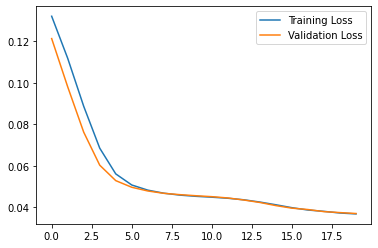

In [47]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

정상 데이터를 오토인코더로 인코딩과 디코딩을 한 후의 신호를 살펴봅니다.

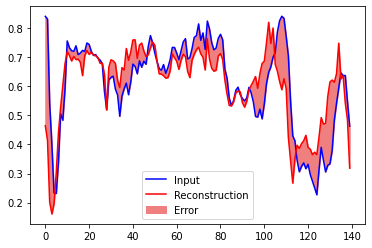

In [48]:
encoded_signals = autoencoder.encoder(normal_X_test).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.plot(normal_X_test[0], 'b', label="Input")
plt.plot(decoded_signals[0], 'r', label="Reconstruction")
plt.fill_between(np.arange(140), decoded_signals[0], normal_X_test[0], 
                        color='lightcoral', label="Error")
plt.legend()
plt.show()

비정상적 데이터 예제에 대한 유사한 플롯 만들기:

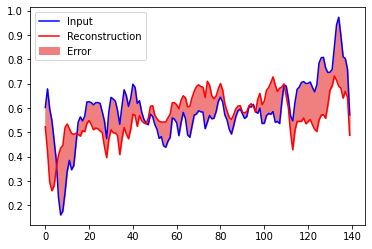

In [50]:
encoded_signals = autoencoder.encoder(abnormal_X_test).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.plot(abnormal_X_test[0], 'b', label="Input")
plt.plot(decoded_signals[0], 'r', label="Reconstruction")
plt.fill_between(np.arange(140), decoded_signals[0], abnormal_X_test[0], 
                        color='lightcoral', label="Error")
plt.legend()
plt.show()

### 이상 감지
재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다. 이를 위해 훈련 세트의 정상 예제에 대한 평균 평균 오류를 계산한 다음 재구성 오류가 훈련 세트의 표준 편차보다 높으면 미래 예제를 비정상적인 것으로 분류합니다.

훈련 세트의 정상 ECG에 대한 재구성 오류를 시각화 합니다.

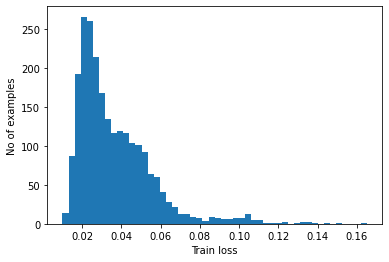

In [51]:
reconstructions = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_X_train).numpy()

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

평균 + 1 표준편차인 임계값을 선택합니다.

In [52]:
threshold_ae = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_ae)

Threshold:  0.0559028351000827


테스트 세트의 대부분의 비정상 example은 임계값보다 재구성 오류가 더 큽니다. 임계값을 변경하여 분류기의 정밀도와 재현율을 조정할 수 있습니다.

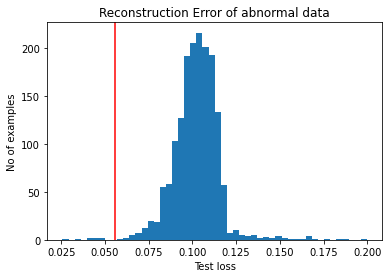

In [54]:
reconstructions = autoencoder.predict(abnormal_X_train)
test_loss = tf.keras.losses.mae(reconstructions, abnormal_X_train).numpy()

plt.hist(test_loss, bins=50)
plt.axvline(threshold_ae, c='r')
plt.title("Reconstruction Error of abnormal data")
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.  
재구성 오류를 이용한 이상치 예측과 label 을 비교하여 performance 를 측정합니다.

In [55]:
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

In [56]:
preds = predict(autoencoder, X_test, threshold_ae)
print_stats(preds.numpy(), y_test)

Accuracy = 0.926
Precision = 1.0
Recall = 0.8747884940778342


### 이상 감지를 위한 Variational Autoencoder
오토인코더는 훈련 데이터에 과적합되는 경향이 강합니다. 이 문제를 완화하도록 설계된 VAE를 사용합니다. 

샘플링 단계를 포함하는 네트워크의 인코더 부분을 정의합니다.

In [58]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
def encoder_model(input_dim, latent_dim):

    prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)

    encoder_input = Input(shape=(input_dim,))
    x = Dense(20, activation=tf.nn.leaky_relu)(encoder_input)
    x = Dense(15, activation=tf.nn.leaky_relu)(x)
    x = Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim), activation=None)(x)
    encoded = tfp.layers.MultivariateNormalTriL(latent_dim, 
                        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior))(x)
    encoder = Model(encoder_input, encoded)
    return encoder

def decoder_model(latent_dim, input_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(15, activation=tf.nn.leaky_relu)(decoder_input)
    x = Dense(20, activation=tf.nn.leaky_relu)(x)
    x = Dense(tfp.layers.IndependentNormal.params_size(input_dim), activation=None)(x)
    decoded = tfp.layers.IndependentNormal(input_dim)(x)

    decoder = Model(decoder_input, decoded)
    return decoder

def vae_model(encoder, decoder):
    vae = Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

    negloglik = lambda x, rv_x: -rv_x.log_prob(x)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=negloglik)
    return vae

In [60]:
input_dim = normal_X_train.shape[1]

latent_dim = 5
encoder = encoder_model(input_dim, latent_dim)

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 dense_7 (Dense)             (None, 20)                2820      
                                                                 
 dense_8 (Dense)             (None, 15)                315       
                                                                 
 dense_9 (Dense)             (None, 20)                320       
                                                                 
 multivariate_normal_tri_l (  ((None, 5),              0         
 MultivariateNormalTriL)      (None, 5))                         
                                                                 
Total params: 3,455
Trainable params: 3,455
Non-trainable params: 0
___________________________________________________________

In [61]:
decoder = decoder_model(latent_dim, input_dim)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_10 (Dense)            (None, 15)                90        
                                                                 
 dense_11 (Dense)            (None, 20)                320       
                                                                 
 dense_12 (Dense)            (None, 280)               5880      
                                                                 
 independent_normal (Indepen  ((None, 140),            0         
 dentNormal)                  (None, 140))                       
                                                                 
Total params: 6,290
Trainable params: 6,290
Non-trainable params: 0
_________________________________________________________

In [62]:
vae = vae_model(encoder, decoder)

vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 dense_7 (Dense)             (None, 20)                2820      
                                                                 
 dense_8 (Dense)             (None, 15)                315       
                                                                 
 dense_9 (Dense)             (None, 20)                320       
                                                                 
 multivariate_normal_tri_l (  ((None, 5),              0         
 MultivariateNormalTriL)      (None, 5))                         
                                                                 
 model_1 (Functional)        (None, 140)               6290      
                                                           

In [67]:
batch_size = 128
max_epochs = 1000

checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)

earlystopper = EarlyStopping(monitor='val_loss', mode='min', 
                             patience=10, verbose=0, restore_best_weights=True)

history = vae.fit(normal_X_train, normal_X_train, 
                  epochs=max_epochs, batch_size=128, shuffle=True,
                  verbose=1, validation_data=(normal_X_test, normal_X_test),
                  callbacks=[earlystopper, checkpointer])

Epoch 1/1000
19/19 [==============================] - 0s 10ms/step - loss: -242.5108 - val_loss: -241.9255
Epoch 2/1000
19/19 [==============================] - 0s 7ms/step - loss: -242.3944 - val_loss: -241.0488
Epoch 3/1000
19/19 [==============================] - 0s 8ms/step - loss: -242.5233 - val_loss: -242.4973
Epoch 4/1000
19/19 [==============================] - 0s 7ms/step - loss: -242.7014 - val_loss: -237.2986
Epoch 5/1000
19/19 [==============================] - 0s 6ms/step - loss: -241.1456 - val_loss: -240.8681
Epoch 6/1000
19/19 [==============================] - 0s 7ms/step - loss: -242.8676 - val_loss: -241.7072
Epoch 7/1000
19/19 [==============================] - 0s 6ms/step - loss: -242.9613 - val_loss: -240.1227
Epoch 8/1000
19/19 [==============================] - 0s 7ms/step - loss: -242.7966 - val_loss: -237.6057
Epoch 9/1000
19/19 [==============================] - 0s 9ms/step - loss: -242.8690 - val_loss: -243.3096
Epoch 10/1000
19/19 [========================

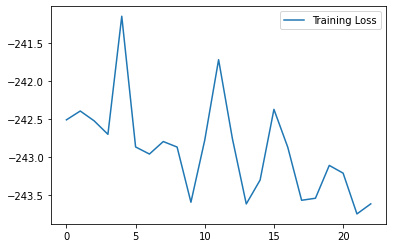

In [69]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

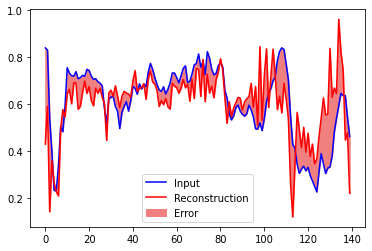

In [71]:
encoded_imgs = encoder(normal_X_test)
decoded_imgs = decoder(encoded_imgs)
plt.plot(normal_X_test[0], 'b', label="Input")
plt.plot(decoded_imgs[0], 'r', label="Reconstruction")
plt.fill_between(np.arange(140), decoded_imgs[0], normal_X_test[0], 
                        color='lightcoral', label="Error")
plt.legend()
plt.show()

이전과 마찬가지로 평균 절대 오차에 표준 편차 1을 더한 값에서 임계값을 계산합니다.

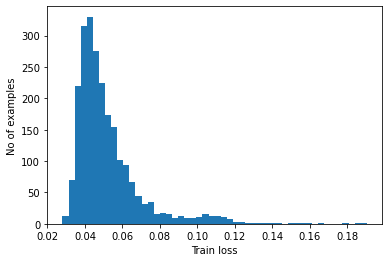

In [72]:
reconstructions = vae.predict(normal_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_X_train).numpy()
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [73]:
threshold_vae = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_vae)

Threshold:  0.0708613513842328


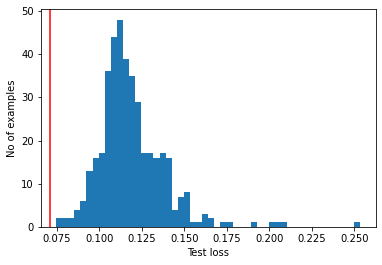

In [74]:
reconstructions = vae.predict(abnormal_X_test)
test_loss = tf.keras.losses.mae(reconstructions, abnormal_X_test).numpy()

plt.hist(test_loss, bins=50)
plt.axvline(threshold_vae,c='r')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.

variational autoencoder

In [75]:
preds = predict(vae, X_test, threshold_vae)
print("Variational Autoencoder")
print_stats(preds, y_test)

Variational Autoencoder
Accuracy = 0.943
Precision = 1.0
Recall = 0.9035532994923858


- autoencoder

In [76]:
preds = predict(autoencoder, X_test, threshold_ae)
print("Autoencoder")
print_stats(preds, y_test)

Autoencoder
Accuracy = 0.926
Precision = 1.0
Recall = 0.8747884940778342


RNN 이진 분류 모델

In [ ]:
print("RNN as classifier")
print('Accuracy = ',accuracy_test_rnn)
print('Precision = ',precision_test_rnn)
print('Recall = ',recall_test_rnn)

RNN as classifier
Accuracy =  0.978
Precision =  0.9729272419627749
Recall =  0.9896729776247849
